# EECS 442 Assignment 5(2) - PyTorch ConvNets, Saliency Maps and Adversarial Attack
In this notebook we will explore how to use a pre-trained PyTorch convolution neural network (ConvNet), generate a saliency map and then fool the same network by using gradient ascent.

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Leo Lee, #02047414

## Setup

In [53]:
import os
import json
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
import pdb
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
SQUEEZENET_MEAN = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float)
SQUEEZENET_STD = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float)
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [54]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = torch.device('cuda:0')
else:
    raise Exception("WARNING: Could not find GPU! Using CPU only. \
To enable GPU, please to go Edit > Notebook Settings > Hardware \
Accelerator and select GPU.")

Using the GPU. You are good to go!


For all of our experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet [1]. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [2], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all experiments without heavy computation. Run the following cell to download and initialize your model.

[1] Olga Russakovsky*, Jia Deng*, Hao Su, Jonathan Krause, Sanjeev Satheesh, Sean Ma, Zhiheng Huang, Andrej Karpathy, Aditya Khosla, Michael Bernstein, Alexander C. Berg and Li Fei-Fei. ImageNet Large Scale Visual Recognition Challenge. IJCV, 2015

[2] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [55]:
print('Download and load the pretrained SqueezeNet model.')
model = torchvision.models.squeezenet1_1(pretrained=True).to(device)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
  param.requires_grad = False
    
# Make sure the model is in "eval" mode
model.eval()

# you may see warning regarding initialization deprecated, that's fine, 
# please continue to next steps

Download and load the pretrained SqueezeNet model.


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

Next, we will download the imagenet labels which we are going to use in the notebook. ImageNet labels are stored in the `idx2label` dictionary of `{index(int): label(str)}`. 

In [4]:
# Loading the imagenet class labels
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

class_idx = json.load(open("imagenet_class_index.json"))
idx2label = {k:class_idx[str(k)][1] for k in range(len(class_idx))}
idx2label

--2021-04-12 02:22:21--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.137.56
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.137.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.06s   

2021-04-12 02:22:21 (543 KB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



{0: 'tench',
 1: 'goldfish',
 2: 'great_white_shark',
 3: 'tiger_shark',
 4: 'hammerhead',
 5: 'electric_ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich',
 10: 'brambling',
 11: 'goldfinch',
 12: 'house_finch',
 13: 'junco',
 14: 'indigo_bunting',
 15: 'robin',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water_ouzel',
 21: 'kite',
 22: 'bald_eagle',
 23: 'vulture',
 24: 'great_grey_owl',
 25: 'European_fire_salamander',
 26: 'common_newt',
 27: 'eft',
 28: 'spotted_salamander',
 29: 'axolotl',
 30: 'bullfrog',
 31: 'tree_frog',
 32: 'tailed_frog',
 33: 'loggerhead',
 34: 'leatherback_turtle',
 35: 'mud_turtle',
 36: 'terrapin',
 37: 'box_turtle',
 38: 'banded_gecko',
 39: 'common_iguana',
 40: 'American_chameleon',
 41: 'whiptail',
 42: 'agama',
 43: 'frilled_lizard',
 44: 'alligator_lizard',
 45: 'Gila_monster',
 46: 'green_lizard',
 47: 'African_chameleon',
 48: 'Komodo_dragon',
 49: 'African_crocodile',
 50: 'American_alligator',
 51: 'triceratops',
 

### Helper Functions

Our pretrained model was trained on images that had been preprocessed by subtracting the per-color mean and dividing by the per-color standard deviation. We define a few helper functions for performing and undoing this preprocessing. You don't need to do anything in this cell.

In [56]:
def preprocess(img, size=224):
  transform = T.Compose([
    T.Resize((size, size)),
    T.ToTensor(),
    T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
          std=SQUEEZENET_STD.tolist()),
    T.Lambda(lambda x: x[None]),
  ])
  return transform(img)

def deprocess(img, should_rescale=True):
  transform = T.Compose([
    T.Lambda(lambda x: x[0]),
    T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
    T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
    T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
    T.ToPILImage(),
  ])
  return transform(img)

def rescale(x):
  low, high = x.min(), x.max()
  x_rescaled = (x - low) / (high - low)
  return x_rescaled
  
def blur_image(X, sigma=1):
  X_np = X.cpu().clone().numpy()
  X_np = gaussian_filter1d(X_np, sigma, axis=2)
  X_np = gaussian_filter1d(X_np, sigma, axis=3)
  X.copy_(torch.Tensor(X_np).type_as(X))
  return X

## Task 1 - Pre-trained Convolution Network
In order to get a better sense of the classification decisions made by convolutional networks, your job is now to experiment by running whatever images you want through a model pretrained on ImageNet. These can be images from your own photo collection, from the internet, or somewhere else but they **should belong to one of the ImageNet classes**. Look at the `idx2label` dictionary for all the ImageNetclasses.

You need to find:
1. One image (`img1`) where the SqueezeNet model gives reasonable predictions, and produces a category label that seems to correctly describe the content of the image
2. One image (`img2`) where the SqueezeNet model gives unreasonable predictions, and produces a category label that does not correctly describe the content of the image.

You can upload images in Colab by using the upload button on the top left. For more details about using Colab, please see our [Colab tutorial](https://web.eecs.umich.edu/~justincj/teaching/eecs442/WI2021/colab.html). 



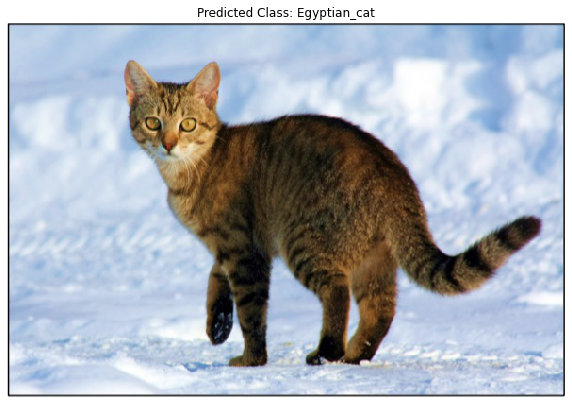

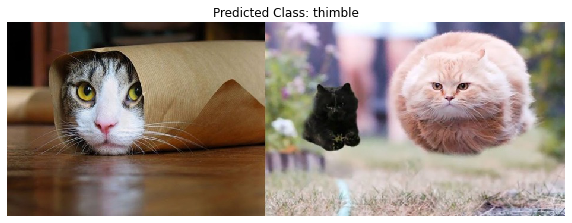

In [58]:
###############################################################################
# TODO: Upload your image and run the forward pass to get the ImageNet class. #
# This code will crash when you run it, since the maxresdefault.jpg image is  #
# not found. You should upload your own images to the Colab notebook and edit #
# these lines to load your own image.                                         #
###############################################################################
img1 = Image.open('img1.jpg')
img2 = Image.open('img2.jpg')
##############################################################################
#               END OF YOUR CODE                                             #
##############################################################################
for img in [img1, img2]:
  X = preprocess(img).to(device)
  pred_class = torch.argmax(model(X)).item()
  plt.imshow(img)
  plt.title('Predicted Class: %s' % idx2label[pred_class])
  plt.axis('off')
  plt.show()

## Task 2 - Saliency Maps
Using this pretrained model, we will compute class saliency maps as described in Section 3.1 of [2].

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(3, H, W)` then this gradient will also have shape `(3, H, W)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

In [59]:
def compute_saliency_maps(X, y, model):
  """
  Compute a class saliency map using the model for images X and labels y.

  Input:
  - X: Input images; Tensor of shape (N, 3, H, W)
  - y: Labels for X; LongTensor of shape (N,)
  - model: A pretrained CNN that will be used to compute the saliency map.

  Returns:
  - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
  images.
  """
  # Make input tensor require gradient
  X.requires_grad_()
  
  saliency = None
  ##############################################################################
  # TODO: Implement this function. Perform a forward and backward pass through #
  # the model to compute the gradient of the correct class score with respect  #
  # to each input image. You first want to compute the loss over the correct    #
  # scores (we'll combine losses across a batch by summing), and then compute  #
  # the gradients with a backward pass.                                        #
  ##############################################################################
  # Replace "pass" statement with your code
  scores = model(X)
  gather = scores[torch.arange(2),y]
  loss = torch.sum(gather)
  
  model.zero_grad()
  loss.backward()
  grad = X.grad
  grad = torch.abs(grad)
  saliency = torch.max(grad,1)[0]
  #print(model.parameters().grad)
  #print(scores.grad)
  #temp = scores[y]
  #print(temp)
  #pdb.set_trace()
  
  ##############################################################################
  #               END OF YOUR CODE                                             #
  ##############################################################################
  return saliency

Once you have completed the implementation in the cell above, run the following to visualize the saliency map for the two images from the previous part.

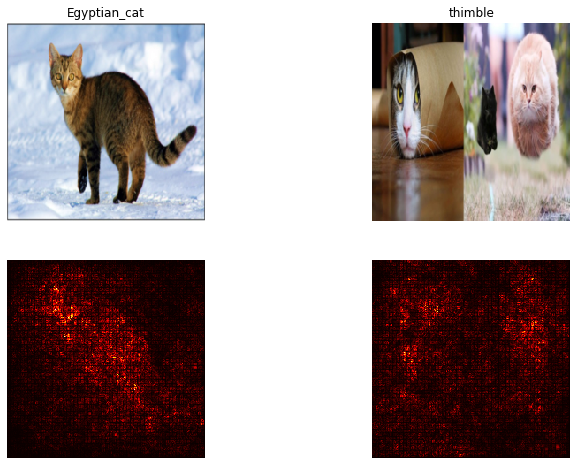

In [60]:
def show_saliency_maps(X_tensor, y_tensor):
  # Compute saliency maps for images in X
  saliency = compute_saliency_maps(X_tensor, y_tensor, model)

  # Convert the saliency map from Torch Tensor to numpy array and show images
  # and saliency maps together.
  saliency = saliency.to('cpu').numpy()
  N = X.shape[0]
  for i in range(N):
    plt.subplot(2, N, i + 1)
    plt.imshow(deprocess(X_tensor[i].cpu().unsqueeze(0)))
    plt.axis('off')
    plt.title(idx2label[y_tensor[i].item()])
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 8)
  plt.show()

##############################################################################
# TODO: Visualize the saliency map for the two images from the previous part #
##############################################################################
img1 = Image.open('img1.jpg') 
img2 = Image.open('img2.jpg') 
##############################################################################
#               END OF YOUR CODE                                             #
##############################################################################
#breakpoint()

X = torch.cat([preprocess(x) for x in [img1, img2]], dim=0).to(device)
y = torch.argmax(model(X), dim=1)
show_saliency_maps(X, y)

## Task 3: Adversarial Attack 
We can use image gradients to generate "adversarial attacks" as discussed in [3].
Given an image and a target class, we can perform gradient descent over the image to maximize the target class, stopping when the network classifies the image as the target class.
Implement the following function to generate adversarial attacks.

[3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

In [61]:
def make_adversarial_attack(X, target_y, model):
  """
  Generate an adversarial attack that is close to X, but that the model classifies
  as target_y.

  Inputs:
  - X: Input image; Tensor of shape (1, 3, 224, 224)
  - target_y: An integer in the range [0, 1000)
  - model: A pretrained CNN

  Returns:
  - X_adv: An image that is close to X, but that is classifed as target_y
  by the model.
  """
  # Initialize our adversarial attack to the input image, and make it require gradient
  X_adv = X.clone()
  X_adv = X_adv.requires_grad_()
  
  learning_rate = 1
  ##############################################################################
  # TODO: Generate an adversarial attack X_adv that the model will classify    #
  # as the class target_y. You should perform gradient ascent on the score     #
  # of the target class, stopping when the model is fooled.                    #
  # When computing an update step, first normalize the gradient:                #
  #   dX = learning_rate * g / ||g||_2                                         #
  #                                                                            #
  # You should write a training loop.                                          #
  #                                                                            #
  # HINT: For most examples, you should be able to generate an adversarial     #
  # attack in fewer than 100 iterations of gradient ascent.                    #
  # You can print your progress over iterations to check your algorithm.       #
  ##############################################################################
  # Replace "pass" statement with your code
  total_iteration = 100
  for i in range(total_iteration):
    scores = model(X_adv)
    max_score = torch.max(scores)
    target_score = scores[0, target_y]
    loss = target_score
    #pdb.set_trace()
    print('Iteration %d: target score %.3f, max score %.3f' %(i, target_score, max_score))

    if target_score >= max_score:
      break
    else:
      model.zero_grad()
      loss.backward()
      dX = X_adv.grad
      #pdb.set_trace()
      dX = dX*learning_rate/torch.norm(dX)
      X_adv.data = X_adv.data + dX
      #pdb.set_trace()


    
    


    
    


  
  ##############################################################################
  #                             END OF YOUR CODE                               #
  ##############################################################################
  return X_adv

Run the following cell to generate an adversarial attack. You should ideally see at first glance no major difference between the original and attacked images, and the network should now make an incorrect prediction on the attacked one. However you should see a bit of random noise if you look at the 10x magnified difference between the original and attacked images. 

Now, use the image from `task 1` which gave the **correct** prediction to fool the neural network.

In [62]:
##############################################################################
# TODO: Use the correctly predicted image from task 1 to fool the network    #
# Choose a class (target_y) from idx2label dictionary to fool the nwtwork    #
##############################################################################
img = Image.open('img1.jpg')
target_y = 6
##############################################################################
#               END OF YOUR CODE                                             #
##############################################################################
X_tensor = preprocess(img).to(device)


print('Print your progress using the following format: \
the model is fooled if the target score and max score are the same.')
print('Iteration %d: target score %.3f, max score %.3f')
X_adv = make_adversarial_attack(X_tensor, target_y, model)

scores = model(X_adv)
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

Print your progress using the following format: the model is fooled if the target score and max score are the same.
Iteration %d: target score %.3f, max score %.3f
Iteration 0: target score 6.283, max score 29.313
Iteration 1: target score 9.812, max score 31.029
Iteration 2: target score 13.651, max score 31.813
Iteration 3: target score 17.727, max score 31.169
Iteration 4: target score 21.441, max score 31.366
Iteration 5: target score 24.708, max score 32.825
Iteration 6: target score 27.629, max score 34.069
Iteration 7: target score 30.402, max score 34.914
Iteration 8: target score 33.255, max score 35.403
Iteration 9: target score 36.175, max score 36.175


After generating an adversarially attacked image, run the following cell to visualize the original image, the attacked image, as well as the difference between them.

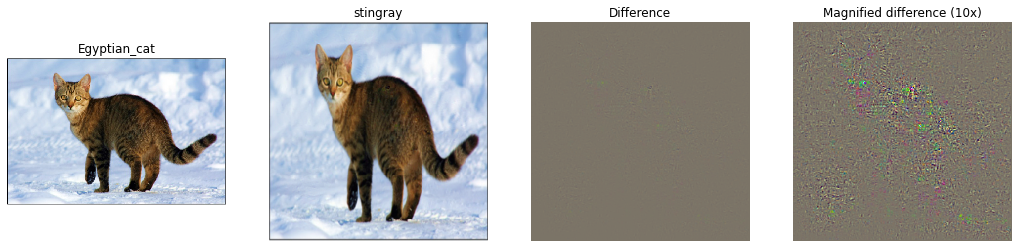

In [63]:
##############################################################################
# TODO: Submit the plot                                                      #
##############################################################################
gt_class = idx2label[torch.argmax(model(X_tensor)).item()]
X_adv = X_adv.to('cpu')
X_adv_np = deprocess(X_adv.clone())
X_adv_np = np.asarray(X_adv_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title(gt_class)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_adv_np)
plt.title(idx2label[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(img)
diff = np.asarray(deprocess(X_adv - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_adv - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(18, 10)
plt.show()